In [1]:
import datajoint as dj
import os
from pathlib import Path

# set dirs
base_dir = Path('/hdd/dj') # change this to your desired directory
if (base_dir).exists() is False:
    os.mkdir(base_dir)
raw_dir = base_dir / 'raw'
if (raw_dir).exists() is False:
    os.mkdir(raw_dir)
analysis_dir = base_dir / 'analysis'
if (analysis_dir).exists() is False:
    os.mkdir(analysis_dir)
recording_dir = base_dir / 'recording'
if (recording_dir).exists() is False:
    os.mkdir(recording_dir)
sorting_dir = base_dir / 'sorting'
if (sorting_dir).exists() is False:
    os.mkdir(sorting_dir)
waveforms_dir = base_dir / 'waveforms'
if (waveforms_dir).exists() is False:
    os.mkdir(waveforms_dir)
tmp_dir = base_dir / 'tmp'
if (tmp_dir).exists() is False:
    os.mkdir(tmp_dir)

# set dj config
dj.config['database.host'] = 'localhost'
dj.config['database.user'] = 'root'
dj.config['database.password'] = 'tutorial'
dj.config['database.port'] = 3306
dj.config['stores'] = {
  'raw': {
    'protocol': 'file',
    'location': str(raw_dir),
    'stage': str(raw_dir)
  },
  'analysis': {
    'protocol': 'file',
    'location': str(analysis_dir),
    'stage': str(analysis_dir)
  }
}

# set env vars
os.environ['SPYGLASS_BASE_DIR'] = str(base_dir)
os.environ['SPYGLASS_RECORDING_DIR'] = str(recording_dir)
os.environ['SPYGLASS_SORTING_DIR'] = str(sorting_dir)
os.environ['SPYGLASS_WAVEFORMS_DIR'] = str(waveforms_dir)
os.environ['SPYGLASS_TEMP_DIR'] = str(tmp_dir)
os.environ['KACHERY_CLOUD_DIR'] = '/hdd/dj/.kachery-cloud'

os.environ['DJ_SUPPORT_FILEPATH_MANAGEMENT'] = 'TRUE'

dj.config["enable_python_native_blobs"] = True

import os
import numpy as np
import importlib

import spyglass as sg
import spyglass.common as sgc
import spyglass.data_import as sgdi
import spyglass.spikesorting as sgs

[2022-10-05 12:55:58,346][INFO]: Connecting root@localhost:3306
[2022-10-05 12:55:58,405][INFO]: Connected root@localhost:3306
/home/kyu/miniconda3/envs/spyglass/lib/python3.8/site-packages/position_tools/core.py:3: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [3]:
# sgc.DataAcquisitionDeviceSystem().delete(safemode=False)
# sgc.DataAcquisitionDeviceAmplifier().delete(safemode=False)
sgc.DataAcquisitionDevice().delete(safemode=False)
sgc.Institution().delete(safemode=False, force_parts=True)
sgc.Lab().delete(safemode=False)
sgc.LabTeam().delete(safemode=False)
sgc.LabMember().delete(safemode=False)
sgc.Subject().delete(safemode=False)
sgc.Session().delete(safemode=False)
sgc.Nwbfile().delete(safemode=False)
sgc.Nwbfile().cleanup(delete_files=True)
sgc.Probe().delete(safemode=False)
sgs.SortGroup().delete(safemode=False)
sgs.SortInterval().delete(safemode=False)
sgs.SpikeSorterParameter().delete(safemode=False)
sgs.SpikeSortingPreprocessingParameter().delete(safemode=False)
sgs.SpikeSortingRecordingSelection().delete(safemode=False)
sgs.ImportedSpikeSorting().delete(safemode=False, force_parts=True)
sgs.Curation().delete(safemode=False)


[2022-10-05 12:56:26,828][INFO]: Deleting 0 rows from `common_device`.`data_acquisition_device`
[2022-10-05 12:56:26,861][INFO]: Deleting 1 rows from `common_ephys`.`_raw`
[2022-10-05 12:56:26,879][INFO]: Deleting 1 rows from `common_interval`.`interval_list`
[2022-10-05 12:56:26,908][INFO]: Deleting 1 rows from `common_session`.`_experimenter_list__experimenter`
[2022-10-05 12:56:26,922][INFO]: Deleting 1 rows from `common_session`.`_experimenter_list`
[2022-10-05 12:56:26,946][INFO]: Deleting 1 rows from `spikesorting_curation`.`curation__imported_spike_sorting`
[2022-10-05 12:56:26,958][INFO]: Deleting 1 rows from `spikesorting_sorting`.`__imported_spike_sorting`
[2022-10-05 12:56:26,973][INFO]: Deleting 1 rows from `common_session`.`_session`
[2022-10-05 12:56:26,988][INFO]: Deleting 1 rows from `common_lab`.`institution`
[2022-10-05 12:56:27,002][INFO]: Deleting 1 rows from `common_lab`.`lab`
[2022-10-05 12:56:27,020][INFO]: Deleting 1 rows from `common_lab`.`lab_team__lab_team_me

1

In [55]:
# Define the name of the file that you copied and renamed; make sure it's something unique. 
# nwb_file_name = 'sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys.nwb'

nwb_file_name = 'sub-MS10_ses-Peter-MS10-170321-164406-concat_behavior+ecephys.nwb'
filename, file_extension = os.path.splitext(nwb_file_name)
# This is a copy of the original nwb file, except it doesn't contain the raw data (for storage reasons)
nwb_file_name2 = filename + '_' + file_extension

In [56]:
from spyglass.utils.nwb_helper_fn import get_all_spatial_series, get_nwb_file

In [57]:
nwb_file_abspath = sgc.Nwbfile.get_abs_path(nwb_file_name)
nwbf = get_nwb_file(nwb_file_abspath)
pos_dict = get_all_spatial_series(nwbf, verbose=True)


/hdd/dj/raw/sub-MS10_ses-Peter-MS10-170321-164406-concat_behavior+ecephys.nwb


In [59]:
pos_dict

In [40]:
import pynwb
with pynwb.NWBHDF5IO('/hdd/dj/raw/sub-MS10_ses-Peter-MS10-170321-164406-concat_behavior+ecephys.nwb', mode='r', load_namespaces=True) as io:
    nwbf = io.read()
    x = np.asarray(nwbf.units['spike_times'][:])

In [52]:
import pynwb
with pynwb.NWBHDF5IO('/hdd/dj/raw/sub-MS10_ses-Peter-MS10-170321-164406-concat_behavior+ecephys.nwb', mode='r', load_namespaces=True) as io:
    nwbf = io.read()
    x = nwbf.processing['behavior'].data_interfaces['SubjectSpeed'].data[:]

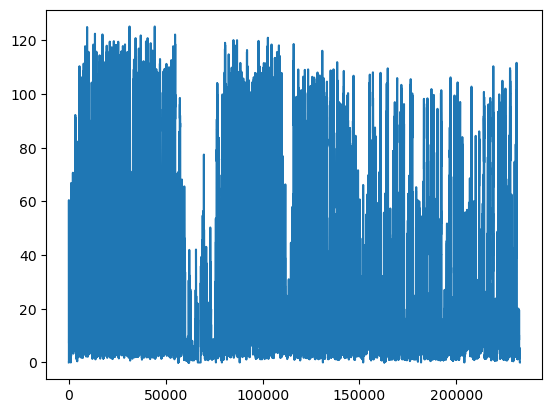

In [54]:
import matplotlib.pyplot as plt
plt.plot(x)

In [32]:
127639440/20000

6381.972

In [30]:
import pynwb
with pynwb.NWBHDF5IO('/hdd/dj/raw/sub-MS10_ses-Peter-MS10-170321-164406-concat_behavior+ecephys.nwb', mode='r', load_namespaces=True) as io:
    nwbf = io.read()
    print(nwbf.processing['behavior'].data_interfaces['SubjectPosition'].spatial_series['SpatialSeries'].timestamps[:])

[ 184.9627   184.97105  184.9794  ... 2124.77065 2124.779   2124.78735]


In [83]:
import pynwb
with pynwb.NWBHDF5IO('/hdd/dj/raw/sub-MS10_ses-Peter-MS10-170321-164406-concat_behavior+ecephys.nwb', mode='r', load_namespaces=True) as io:
    nwbf = io.read()
    print(nwbf.intervals['trials'][:])

      start_time    stop_time condition  error cooling state
id                                                          
0      25.358333    28.958333      Left  False   Pre-Cooling
1      39.500000    45.741667      Left  False   Pre-Cooling
2      49.375000    52.341667     Right  False   Pre-Cooling
3      55.425000    58.175000      Left  False   Pre-Cooling
4      61.233333    63.933333     Right  False   Pre-Cooling
..           ...          ...       ...    ...           ...
125  1845.983333  1853.125000     Right   True  Post-Cooling
126  1858.650000  1866.158333      Left   True  Post-Cooling
127  1875.200000  1878.791667     Right  False  Post-Cooling
128  1891.075000  1899.575000      Left   True  Post-Cooling
129  1923.791667  1926.700000     Right  False  Post-Cooling

[130 rows x 5 columns]


In [57]:
import pynwb

with pynwb.NWBHDF5IO('/hdd/dj/raw/sub-MS10_ses-Peter-MS10-170321-164406-concat_behavior+ecephys.nwb', mode='r', load_namespaces=True) as io:
    nwbf = io.read()
    # print(nwbf.processing['behavior'].data_interfaces['SubjectPosition'].spatial_series['SpatialSeries'].data[:,:2])
    position = nwbf.processing['behavior'].data_interfaces['SubjectPosition'].spatial_series['SpatialSeries'].data[:,:2]
    position_timestamps = nwbf.processing['behavior'].data_interfaces['SubjectPosition'].spatial_series['SpatialSeries'].timestamps[:]
    units = nwbf.units.to_dataframe()

In [81]:
x.to_numpy()

array([[25.358333, 28.958333000000003, 'Left', False, 'Pre-Cooling'],
       [39.5, 45.741667, 'Left', False, 'Pre-Cooling'],
       [49.375, 52.341667, 'Right', False, 'Pre-Cooling'],
       [55.425, 58.175, 'Left', False, 'Pre-Cooling'],
       [61.233332999999995, 63.933333, 'Right', False, 'Pre-Cooling'],
       [69.408333, 72.141667, 'Left', False, 'Pre-Cooling'],
       [75.69166700000001, 79.091667, 'Right', False, 'Pre-Cooling'],
       [83.825, 86.425, 'Left', False, 'Pre-Cooling'],
       [89.483333, 98.06666700000001, 'Right', False, 'Pre-Cooling'],
       [102.366667, 105.1, 'Left', False, 'Pre-Cooling'],
       [107.86666699999999, 112.375, 'Right', False, 'Pre-Cooling'],
       [116.05, 118.84166699999999, 'Left', False, 'Pre-Cooling'],
       [123.266667, 126.308333, 'Right', False, 'Pre-Cooling'],
       [129.98333300000002, 132.60833300000002, 'Left', False,
        'Pre-Cooling'],
       [136.783333, 139.89166699999998, 'Right', False, 'Pre-Cooling'],
       [142.4583

In [58]:
position_timestamps

array([ 184.9627 ,  184.97105,  184.9794 , ..., 2124.77065, 2124.779  ,
       2124.78735])

In [8]:
from replay_trajectory_classification.sorted_spikes_simulation import make_simulated_run_data

time, position, sampling_frequency, spikes, place_fields = make_simulated_run_data()

In [32]:
import pynwb

with pynwb.NWBHDF5IO('/hdd/dj/raw/sub-MS10_ses-Peter-MS10-170321-164406-concat_behavior+ecephys.nwb', mode='r', load_namespaces=True) as io:
    nwbf = io.read()
    # print(nwbf.processing['behavior'].data_interfaces['SubjectPosition'].spatial_series['SpatialSeries'])?
    print(nwbf.acquisition)

{'ElectricalSeries': ElectricalSeries pynwb.ecephys.ElectricalSeries at 0x140276422238992
Fields:
  comments: Generated from SpikeInterface::NwbRecordingExtractor
  conversion: 1.9499999999999999e-07
  data: <HDF5 dataset "data": shape (127639440, 64), type "<i2">
  description: Raw acquisition traces.
  electrodes: electrodes <class 'hdmf.common.table.DynamicTableRegion'>
  rate: 20000.0
  resolution: -1.0
  starting_time: 0.0
  starting_time_unit: seconds
  unit: volts
}


In [17]:
1/np.mean(np.diff(position_timestamps))

120.00569226708198

In [61]:
max(units['spike_times'][0])

6371.54755

In [15]:
import matplotlib.pyplot as plt

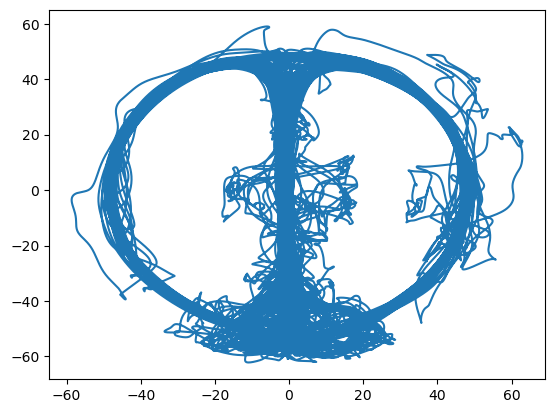

In [16]:
plt.plot(position[:,0], position[:,1])

In [78]:
position_timestamps

array([ 184.9627 ,  184.97105,  184.9794 , ..., 2124.77065, 2124.779  ,
       2124.78735])

In [67]:

units

,quality,spike_times,pc_features,amplitudes
id,,,,
0,unsorted,"[84.883, 85.19985, 85.2342, 85.7704, 85.8168, ...","[[[7.859584, -0.11860795, -1.8301122, -2.18864...","[12.93914794921875, 14.4837646484375, 15.46664..."
1,unsorted,"[10.49655, 85.60505, 85.776, 85.97765, 86.1824...","[[[92.269394, 1.4977138, -57.088196, 9.025064,...","[205.52349853515625, 18.0914306640625, 19.0762..."
2,unsorted,"[84.73195, 85.3307, 85.7076, 86.33915, 86.7044...","[[[0.5133911, 2.9865193, 1.6772459, 1.0116271,...","[12.235107421875, 13.3089599609375, 11.6058349..."
3,unsorted,"[2198.74495, 2291.55305, 2331.98975, 2331.993,...","[[[125.668915, -98.91967, 2.1854315, 1.5543464...","[29.536865234375, 16.2421875, 17.779052734375,..."
4,unsorted,"[5.56165, 84.65305, 84.9388, 84.94715, 85.0433...","[[[1.3360919, -6.102194, -4.7450533, 0.6406456...","[19.541900634765625, 17.813568115234375, 17.47..."
...,...,...,...,...
379,unsorted,"[2.17565, 16.45265, 22.0163, 23.2849, 23.28495...","[[[11.930531, 16.906515, 1.1756591, 0.43625945...","[14.7396240234375, 16.033538818359375, 33.0386..."
380,unsorted,"[2.1111, 3.88275, 3.88895, 3.9364, 5.2792, 5.2...","[[[9.179077, -0.035359886, 1.022065, 6.5947433...","[17.18170166015625, 13.87646484375, 13.6484375..."
381,unsorted,"[702.29215, 997.74855, 1028.63965, 1448.9191, ...","[[[21.19208, 9.402719, 4.876995, 5.325213, 2.9...","[36.4827880859375, 10.85211181640625, 22.80450..."


In [1]:
import pynwb
import numpy as np
from scipy import interpolate

with pynwb.NWBHDF5IO('/hdd/dj/raw/sub-MS10_ses-Peter-MS10-170321-164406-concat_behavior+ecephys.nwb', mode='r', load_namespaces=True) as io:
    nwbf = io.read()
    position = nwbf.processing['behavior'].data_interfaces['SubjectPosition'].spatial_series['SpatialSeries'].data[:,:2]
    position_timestamps = nwbf.processing['behavior'].data_interfaces['SubjectPosition'].spatial_series['SpatialSeries'].timestamps[:]
    units = nwbf.units.to_dataframe()                                                                                                            
spike_times_list = units['spike_times'].to_numpy()
sampling_rate = 20000
start_time = position_timestamps[0]
# end_time = 127639440/20000
end_time = position_timestamps[-1]
bin_size = 0.002
bin_edges = np.arange(start_time, end_time, bin_size)
n_bins = int((end_time-start_time)/bin_size)
n_units = len(spike_times_list)

spike_indicator = np.zeros((n_bins, n_units))
for unit in range(n_units):
    spike_times = spike_times_list[unit]
    spike_times = spike_times[(spike_times > start_time) & (spike_times < end_time)]
    for spike in spike_times:
        spike_indicator[np.searchsorted(bin_edges, spike), unit] = 1

        
f = interpolate.interp1d(position_timestamps, position, axis=0)
position_interp = f(bin_edges[1:])

/home/kyu/miniconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/kyu/miniconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.4.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/kyu/miniconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/utils.py:629: FutureWarning: DynamicTable.__init__: Using positional arguments for this method is discouraged and will be deprecated in a future major release. Please use keyword arguments to ensure future compatibility.
  warnings.warn(msg, FutureWarning)
/home/kyu/miniconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/utils.py:629: FutureWarning: DynamicTa

In [2]:
from replay_trajectory_classification import SortedSpikesDecoder, Environment, RandomWalk, estimate_movement_var

environment = Environment(place_bin_size=2.0)
transition_type = RandomWalk(movement_var=6.0)

decoder = SortedSpikesDecoder(
    environment=environment,
    transition_type=transition_type,
    sorted_spikes_algorithm='spiking_likelihood_kde',
    sorted_spikes_algorithm_params={'block_size': None,
                                    'position_std': 3.0},
)

decoder.fit(position_interp, spike_indicator)

SortedSpikesDecoder(environment=Environment(environment_name='', place_bin_size=2.0, track_graph=None, edge_order=None, edge_spacing=None, is_track_interior=None, position_range=None, infer_track_interior=True, fill_holes=False, dilate=False, bin_count_threshold=0),
                    infer_track_interior=True,
                    initial_conditions_type=UniformInitialConditions(),
                    sorted_spikes_algorithm='spiking_likelihood_kde',
                    sorted_spikes_algorithm_params={'block_size': None,
                                                    'position_std': 3.0},
                    transition_type=RandomWalk(environment_name='', movement_var=6.0, movement_mean=0.0, use_diffusion=False))

In [ ]:
results = decoder.predict(spike_indicator, use_gpu=True)

  0%|          | 0/344 [00:00<?, ?it/s]

In [29]:
decoder

SortedSpikesDecoder(environment=Environment(environment_name='', place_bin_size=2.0, track_graph=None, edge_order=None, edge_spacing=None, is_track_interior=None, position_range=None, infer_track_interior=True, fill_holes=False, dilate=False, bin_count_threshold=0),
                    infer_track_interior=True,
                    initial_conditions_type=UniformInitialConditions(),
                    sorted_spikes_algorithm='spiking_likelihood_kde',
                    sorted_spikes_algorithm_params={'block_size': None,
                                                    'position_std': 3.0},
                    transition_type=RandomWalk(environment_name='', movement_var=6.0, movement_mean=0.0, use_diffusion=False))

In [11]:
decoder.fit?

Signature: decoder.fit(position, spikes, is_training=None)
Docstring:
Parameters
----------
position : np.ndarray, shape (n_time, n_position_dims)
spikes : np.ndarray, shape (n_time, n_neurons)
is_training : None or bool np.ndarray, shape (n_time), optional
    Time bins to be used for encoding.

Returns
-------
self
File:      ~/repos/replay_trajectory_classification/replay_trajectory_classification/decoder.py
Type:      method


In [8]:
from replay_trajectory_classification.sorted_spikes_simulation import make_simulated_run_data

time, position_example, sampling_frequency, spikes, place_fields = make_simulated_run_data()

In [3]:
from replay_trajectory_classification import SortedSpikesDecoder, Environment, RandomWalk, estimate_movement_var

movement_var = estimate_movement_var(position, sampling_rate)

environment = Environment(place_bin_size=np.sqrt(movement_var))
transition_type = RandomWalk(movement_var=movement_var)

decoder = SortedSpikesDecoder(
    environment=environment,
    transition_type=transition_type,
    sorted_spikes_algorithm='spiking_likelihood_kde',
    sorted_spikes_algorithm_params={'block_size': None,
                                    'position_std': [3.0],
                                    'use_diffusion': False},
)
decoder.fit(position, spike_indicator)

Cupy is not installed or GPU is not detected. Ignore this message if not using GPU


ValueError: `bins[1]` must be monotonically increasing, when an array

In [85]:
spike_times

array([  84.883  ,   85.19985,   85.2342 , ...,  843.1181 , 1076.0763 ,
       1142.07585])

In [68]:
spike_times_list = units['spike_times'].to_numpy()

In [73]:
len(spike_times_list)

344

In [70]:
spikes = np.concatenate(spike_times_list)

In [74]:
from replay_trajectory_classification.sorted_spikes_simulation import make_simulated_run_data

time, position, sampling_frequency, spikes, place_fields = make_simulated_run_data()

In [76]:
spikes.shape

(360000, 19)

In [ ]:
spikes = np.concatenate(spike_times_list)

# Bin spikes into time bins
spike_indicator = []
for spike_times in spikes:
    spike_times = spike_times[(spike_times > time[0]) & (
        spike_times <= time[-1])]
    spike_indicator.append(np.bincount(np.digitize(
        spike_times, time[1:-1]), minlength=time.shape[0]))

column_names = np.concatenate(
    [[f'{n_trode["sort_group_id"]:04d}_{unit_number:04d}'for unit_number in n_trode['units'].index]
     for n_trode in spikes_nwb])
spike_indicator = pd.DataFrame(np.stack(spike_indicator, axis=1),
                               index=pd.Index(time, name='time'),
                               columns=column_names)

In [66]:
end_time

6381.972

In [7]:
# import pynwb

# with pynwb.NWBHDF5IO('/hdd/dj/raw/sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb', mode='r', load_namespaces=True) as io:
#     nwbf = io.read()
#     print(nwbf.acquisition['ElectricalSeries_raw'].data.file)

Add Neuropixels 1.0 to `Probe`

In [8]:
import numpy as np
import probeinterface as pi

from spyglass.common import Probe

probe_group = pi.read_probeinterface("../franklab_scripts/NP1_standard_config.json")

assert len(probe_group.probes) == 1
for p in probe_group.probes:
    assert len(np.unique(p.shank_ids)) == 1  # multi-shank is not yet supported in this code
    assert p.ndim == 2  # 1-D and 3-D probes are not yet supported in this code
    assert p.si_units == "um"

    probe_dict = dict()
    probe_dict["probe_type"] = p.annotations["probe_name"]
    probe_dict["probe_description"] = str(p.annotations)
    probe_dict["num_shanks"] = 1
    probe_dict["contact_side_numbering"] = "False"
    Probe.insert1(probe_dict)

    shank_dict = dict()
    shank_dict["probe_type"] = probe_dict["probe_type"]
    shank_dict["probe_shank"] = 0
    Probe.Shank.insert1(shank_dict)

    for elect_id, (p, s, sp) in enumerate(zip(p.contact_positions, p.contact_shapes, p.contact_shape_params)):
        elect_dict = dict()
        elect_dict["probe_type"] = probe_dict["probe_type"]
        elect_dict["probe_shank"] = shank_dict["probe_shank"]
        if s == "square":
            elect_dict["contact_size"] = sp["width"]
        elif s == "circle":
            elect_dict["contact_size"] = sp["radius"]
        elif s == "rect":
            if "width" in sp and "height" not in sp:
                elect_dict["contact_size"] = sp["width"]
            else:
                raise ValueError("Rectangular contact shape must have width and not height.")
        else:
            raise ValueError(f"Contact shapes that are not rect, square, or circle are not yet supported: {s}")
        elect_dict['probe_electrode'] = elect_id
        elect_dict['rel_x'] = p[0]
        elect_dict['rel_y'] = p[1]
        Probe.Electrode.insert1(elect_dict)


In [60]:
sgdi.insert_sessions(nwb_file_name)

Creating a copy of NWB file sub-MS10_ses-Peter-MS10-170321-164406-concat_behavior+ecephys.nwb with link to raw ephys data: sub-MS10_ses-Peter-MS10-170321-164406-concat_behavior+ecephys_.nwb
Populate Session...
/hdd/dj/raw/sub-MS10_ses-Peter-MS10-170321-164406-concat_behavior+ecephys_.nwb
Institution...

Lab...

LabMember...
Please add the Google user ID for Peter Petersen in the LabMember.LabMemberInfo table if you want to give them permission to manually curate sortings by this team.

Subject...

DataAcquisitionDevice...
No conforming data acquisition device metadata found.

CameraDevice...
No conforming camera device metadata found.

Probe...
No conforming probe metadata found.

Skipping Apparatus for now...
IntervalList...
No epochs found in NWB file.


Populate ExperimenterList...

Populate Raw...
Importing raw data: Sampling rate:	20000.0 Hz
Number of valid intervals:	1

Populate Electrode...

Populate SampleCount...
Unable to import SampleCount: no data interface named "sample_co

In [63]:
sgc.IntervalList().fetch()

array([('sub-MS10_ses-Peter-MS10-170321-164406-concat_behavior+ecephys_.nwb', 'raw data valid times', array([[   0.   , 6381.972]]))],
      dtype=[('nwb_file_name', 'O'), ('interval_list_name', 'O'), ('valid_times', 'O')])

In [64]:
sgc.PositionSource.insert1([nwb_file_name2, 'raw data valid times', 'nwb', nwb_file_name2])

In [67]:
sgc.RawPosition().populate()

TypeError: 'NoneType' object is not iterable

In [10]:
sgc.PositionSource.insert_from_nwbfile(nwb_file_name)

/hdd/dj/raw/sub-MS10_ses-Peter-MS10-170321-164406-concat_behavior+ecephys.nwb


In [11]:
sgc.PositionSource()

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,"source source of data; current options are ""trodes"" and ""dlc"" (deep lab cut)",import_file_name path to import file if importing position data


In [7]:
sgc.RawPosition()

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,raw_position_object_id the object id of the spatial series for this epoch in the NWB file


In [5]:
sgs.ImportedSpikeSorting.populate([(sgc.Session & {'nwb_file_name': nwb_file_name2}).proj()])

In [6]:
sgs.Curation.ImportedSpikeSorting()

curation_id,nwb_file_name name of the NWB file
97e945be-065c-44c4-8c02-c248b05a086a,sub-MS10_ses-Peter-MS10-170321-164406-concat_behavior+ecephys_.nwb


In [ ]:
from replay_trajectory_classification import SortedSpikesDecoder, Environment, RandomWalk, estimate_movement_var

movement_var = estimate_movement_var(position, sampling_frequency)

In [10]:
sgs.SortGroup().set_group_by_shank(nwb_file_name=nwb_file_name2)

In [11]:
sgs.SortGroup()

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,probe_type,probe_shank shank number within probe,"sort_reference_electrode_id the electrode to use for reference. -1: no reference, -2: common median"
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,Neuropixels 1.0,0,-1


In [12]:
sgs.SortGroup.SortGroupElectrode()

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,electrode_id the unique number for this electrode
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,0
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,1
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,2
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,3
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,4
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,5
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,6
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,7
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,8
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,9


In [13]:
sgc.Electrode()

nwb_file_name name of the NWB file,electrode_id the unique number for this electrode,raw_object_name name of the raw data object (e.g. ElectricalSeries),probe_type,probe_shank shank number within probe,probe_electrode electrode,region_id,name unique label for each contact,original_reference_electrode the configured reference electrode for this electrode,x the x coordinate of the electrode position in the brain,y the y coordinate of the electrode position in the brain,z the z coordinate of the electrode position in the brain,filtering description of the signal filtering,impedance electrode impedance,"bad_channel if electrode is ""good"" or ""bad"" as observed during recording",x_warped x coordinate of electrode position warped to common template brain,y_warped y coordinate of electrode position warped to common template brain,z_warped z coordinate of electrode position warped to common template brain,contacts label of electrode contacts used for a bipolar signal - current workaround
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,ElectricalSeries_raw,Neuropixels 1.0,0,0,2,0,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,1,ElectricalSeries_raw,Neuropixels 1.0,0,1,2,1,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,2,ElectricalSeries_raw,Neuropixels 1.0,0,2,2,2,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,3,ElectricalSeries_raw,Neuropixels 1.0,0,3,2,3,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,4,ElectricalSeries_raw,Neuropixels 1.0,0,4,2,4,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,5,ElectricalSeries_raw,Neuropixels 1.0,0,5,2,5,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,6,ElectricalSeries_raw,Neuropixels 1.0,0,6,2,6,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,7,ElectricalSeries_raw,Neuropixels 1.0,0,7,2,7,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,8,ElectricalSeries_raw,Neuropixels 1.0,0,8,2,8,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,9,ElectricalSeries_raw,Neuropixels 1.0,0,9,2,9,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,


In [14]:
key = {'nwb_file_name': nwb_file_name2,
       'sort_interval_name': 'test',
       'sort_interval': sgc.IntervalList().fetch()['valid_times'][0][0]}
sgs.SortInterval.insert1(key)

In [15]:
sgs.SortInterval()

nwb_file_name name of the NWB file,sort_interval_name name for this interval,sort_interval 1D numpy array with start and end time for a single interval to be used for spike sorting
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,test,=BLOB=


In [16]:
sgs.SpikeSorterParameters().insert_default()
sgs.SpikeSorterParameters()

/home/kyu/repos/spikeinterface/spikeinterface/sorters/sorterlist.py:98: DeprecationWarning: Use get_default_sorter_params() function instead
  warnings.warn("Use get_default_sorter_params() function instead",
/home/kyu/miniconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/blob.py:191: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  if isinstance(obj, collections.Mapping):
/home/kyu/repos/spikeinterface/spikeinterface/sorters/sorterlist.py:98: DeprecationWarning: Use get_default_sorter_params() function instead
  warnings.warn("Use get_default_sorter_params() function instead",
/home/kyu/repos/spikeinterface/spikeinterface/sorters/sorterlist.py:98: DeprecationWarning: Use get_default_sorter_params() function instead
  warnings.warn("Use get_default_sorter_params() function instead",
/home/kyu/miniconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/blob.

sorter,sorter_params_name,sorter_params
clusterless_thresholder,default_clusterless,=BLOB=
combinato,default,=BLOB=
hdsort,default,=BLOB=
herdingspikes,default,=BLOB=
ironclust,default,=BLOB=
kilosort,default,=BLOB=
kilosort2,default,=BLOB=
kilosort2_5,default,=BLOB=
kilosort3,default,=BLOB=
klusta,default,=BLOB=


In [17]:
sgs.SpikeSortingPreprocessingParameters().insert_default()
sgs.SpikeSortingPreprocessingParameters()

preproc_params_name,preproc_params
default,=BLOB=


In [18]:
sgc.LabTeam()

team_name,team_description
Grad Student One,
Grad Student Three,
Grad Student Two,


In [19]:
sgc.IntervalList()

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,valid_times numpy array with start and end times for each interval
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,raw data valid times,=BLOB=


In [20]:
key = {'nwb_file_name': nwb_file_name2,
       'sort_group_id': 0,
       'sort_interval_name': 'test',
       'preproc_params_name': 'default',
       'team_name': 'Grad Student One',
       'interval_list_name': 'raw data valid times'}
sgs.SpikeSortingRecordingSelection().insert1(key)

In [21]:
sgc.Electrode()

nwb_file_name name of the NWB file,electrode_id the unique number for this electrode,raw_object_name name of the raw data object (e.g. ElectricalSeries),probe_type,probe_shank shank number within probe,probe_electrode electrode,region_id,name unique label for each contact,original_reference_electrode the configured reference electrode for this electrode,x the x coordinate of the electrode position in the brain,y the y coordinate of the electrode position in the brain,z the z coordinate of the electrode position in the brain,filtering description of the signal filtering,impedance electrode impedance,"bad_channel if electrode is ""good"" or ""bad"" as observed during recording",x_warped x coordinate of electrode position warped to common template brain,y_warped y coordinate of electrode position warped to common template brain,z_warped z coordinate of electrode position warped to common template brain,contacts label of electrode contacts used for a bipolar signal - current workaround
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,ElectricalSeries_raw,Neuropixels 1.0,0,0,2,0,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,1,ElectricalSeries_raw,Neuropixels 1.0,0,1,2,1,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,2,ElectricalSeries_raw,Neuropixels 1.0,0,2,2,2,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,3,ElectricalSeries_raw,Neuropixels 1.0,0,3,2,3,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,4,ElectricalSeries_raw,Neuropixels 1.0,0,4,2,4,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,5,ElectricalSeries_raw,Neuropixels 1.0,0,5,2,5,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,6,ElectricalSeries_raw,Neuropixels 1.0,0,6,2,6,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,7,ElectricalSeries_raw,Neuropixels 1.0,0,7,2,7,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,8,ElectricalSeries_raw,Neuropixels 1.0,0,8,2,8,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,9,ElectricalSeries_raw,Neuropixels 1.0,0,9,2,9,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,


In [22]:
sgs.SortGroup.SortGroupElectrode()

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,electrode_id the unique number for this electrode
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,0
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,1
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,2
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,3
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,4
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,5
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,6
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,7
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,8
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,9


In [23]:
sgs.SpikeSortingRecordingSelection()

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,interval_list_name descriptive name of this interval list
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,test,default,Grad Student One,raw data valid times


In [24]:
sgs.SortGroup.SortGroupElectrode * sgc.Electrode

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,electrode_id the unique number for this electrode,raw_object_name name of the raw data object (e.g. ElectricalSeries),probe_type,probe_shank shank number within probe,probe_electrode electrode,region_id,name unique label for each contact,original_reference_electrode the configured reference electrode for this electrode,x the x coordinate of the electrode position in the brain,y the y coordinate of the electrode position in the brain,z the z coordinate of the electrode position in the brain,filtering description of the signal filtering,impedance electrode impedance,"bad_channel if electrode is ""good"" or ""bad"" as observed during recording",x_warped x coordinate of electrode position warped to common template brain,y_warped y coordinate of electrode position warped to common template brain,z_warped z coordinate of electrode position warped to common template brain,contacts label of electrode contacts used for a bipolar signal - current workaround
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,0,ElectricalSeries_raw,Neuropixels 1.0,0,0,2,0,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,1,ElectricalSeries_raw,Neuropixels 1.0,0,1,2,1,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,2,ElectricalSeries_raw,Neuropixels 1.0,0,2,2,2,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,3,ElectricalSeries_raw,Neuropixels 1.0,0,3,2,3,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,4,ElectricalSeries_raw,Neuropixels 1.0,0,4,2,4,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,5,ElectricalSeries_raw,Neuropixels 1.0,0,5,2,5,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,6,ElectricalSeries_raw,Neuropixels 1.0,0,6,2,6,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,7,ElectricalSeries_raw,Neuropixels 1.0,0,7,2,7,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,8,ElectricalSeries_raw,Neuropixels 1.0,0,8,2,8,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,9,ElectricalSeries_raw,Neuropixels 1.0,0,9,2,9,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,


In [25]:
sgs.SpikeSortingRecording.populate()

/home/kyu/miniconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


write_binary_recording with n_jobs = 1 and chunk_size = 1302083


In [26]:
sgs.SpikeSortingRecording()

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,recording_path,sort_interval_list_name descriptive name of this interval list
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,test,default,Grad Student One,/hdd/dj/recording/sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb_test_0_default,sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb_test_0_default


In [42]:
sgs.SpikeSorterParameters()

sorter,sorter_params_name,sorter_params
clusterless_thresholder,default_clusterless,=BLOB=
combinato,default,=BLOB=
hdsort,default,=BLOB=
herdingspikes,default,=BLOB=
ironclust,default,=BLOB=
kilosort,default,=BLOB=
kilosort2,default,=BLOB=
kilosort2_5,default,=BLOB=
kilosort3,default,=BLOB=
klusta,default,=BLOB=


In [44]:
ks_params = (sgs.SpikeSorterParameters & {'sorter': 'kilosort2'}).fetch1()

In [46]:
ks_params['sorter_params']['docker_image']=True

In [48]:
ks_params['sorter_params_name'] = 'ks_test'

In [49]:
sgs.SpikeSorterParameters.insert1(ks_params)

In [50]:
sgs.SpikeSorterParameters()

sorter,sorter_params_name,sorter_params
clusterless_thresholder,default_clusterless,=BLOB=
combinato,default,=BLOB=
hdsort,default,=BLOB=
herdingspikes,default,=BLOB=
ironclust,default,=BLOB=
kilosort,default,=BLOB=
kilosort2,default,=BLOB=
kilosort2,ks_test,=BLOB=
kilosort2_5,default,=BLOB=
kilosort3,default,=BLOB=


In [54]:
sgs.ArtifactDetectionParameters().insert_default()

In [55]:
sgs.ArtifactDetectionParameters()

artifact_params_name,artifact_params dictionary of parameters
default,=BLOB=
none,=BLOB=


In [58]:
key['artifact_params_name'] = 'none'

In [61]:
key.pop('interval_list_name')

'raw data valid times'

In [62]:
sgs.ArtifactDetectionSelection.insert1(key)

In [63]:
sgs.ArtifactDetectionSelection()

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,artifact_params_name,custom_artifact_detection
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,test,default,Grad Student One,none,0


In [64]:
sgs.ArtifactDetection.populate()

Amplitude and zscore thresholds are both None, skipping artifact detection


In [65]:
sgs.ArtifactDetection()

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,artifact_params_name,artifact_times np array of artifact intervals,artifact_removed_valid_times np array of valid no-artifact intervals,artifact_removed_interval_list_name name of the array of no-artifact valid time intervals
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,test,default,Grad Student One,none,=BLOB=,=BLOB=,sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb_test_0_default_none_artifact_removed_valid_times


In [66]:
sgs.ArtifactRemovedIntervalList()

artifact_removed_interval_list_name,nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,artifact_params_name,artifact_removed_valid_times,artifact_times np array of artifact intervals
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb_test_0_default_none_artifact_removed_valid_times,sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,test,default,Grad Student One,none,=BLOB=,=BLOB=


In [70]:
key.pop('artifact_params_name')

'none'

In [71]:
sgs.SpikeSortingSelection.insert1(key)

In [67]:
key['sorter'] = 'kilosort2'
key['sorter_params_name'] = 'ks_test'
key['artifact_removed_interval_list_name'] = 'sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb_test_0_default_none_artifact_removed_valid_times'

In [72]:
sgs.SpikeSorting.populate()

Running spike sorting on {'nwb_file_name': 'sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb', 'sort_group_id': 0, 'sort_interval_name': 'test', 'preproc_params_name': 'default', 'team_name': 'Grad Student One', 'sorter': 'kilosort2', 'sorter_params_name': 'ks_test', 'artifact_removed_interval_list_name': 'sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb_test_0_default_none_artifact_removed_valid_times'}...


/home/kyu/miniconda3/envs/spyglass/lib/python3.8/site-packages/docker/utils/utils.py:52: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  s1 = StrictVersion(v1)
/home/kyu/miniconda3/envs/spyglass/lib/python3.8/site-packages/docker/utils/utils.py:53: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  s2 = StrictVersion(v2)
/home/kyu/repos/spikeinterface/spikeinterface/sorters/runsorter.py:230: ResourceWarning: unclosed <socket.socket fd=74, family=AddressFamily.AF_UNIX, type=SocketKind.SOCK_STREAM, proto=0, raddr=/run/docker.sock>
  if self._get_docker_image(container_image) is None:
/home/kyu/repos/spikeinterface/spikeinterface/sorters/runsorter.py:230: ResourceWarning: unclosed <socket.socket fd=75, family=AddressFamily.AF_UNIX, type=SocketKind.SOCK_STREAM, proto=0, raddr=/run/docker.sock>
  if self._get_docker_image(container_image) is None:
/home/kyu/miniconda3/envs/spyglass/lib/python3.8/email

Saving sorting results...


/home/kyu/repos/spikeinterface/spikeinterface/core/basesorting.py:121: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn(
/home/kyu/miniconda3/envs/spyglass/lib/python3.8/tempfile.py:818: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/hdd/dj/tmp/tmplusg9rzq'>
  _warnings.warn(warn_message, ResourceWarning)


In [73]:
sgs.SpikeSorting()

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,sorting_path,"time_of_sort in Unix time, to the nearest second"
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,test,default,Grad Student One,kilosort2,ks_test,sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb_test_0_default_none_artifact_removed_valid_times,/hdd/dj/sorting/sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb_test_0_default_8f0d887a_spikesorting,1661472296


In [3]:
import spikeinterface as si
recording_path = sgs.SpikeSortingRecording().fetch('recording_path')[0]
recording = si.load_extractor(recording_path)

In [4]:
import spikeinterface as si
sorting_path = sgs.SpikeSorting().fetch('sorting_path')[0]
sorting = si.load_extractor(sorting_path)

In [26]:
print([len(sorting.get_unit_spike_train(unit_id = unit_id)) for unit_id in sorting.get_unit_ids()])

[1905, 38, 12851, 3317, 267, 29, 32898, 18664, 34605, 14002, 14015, 25241, 29, 10340, 1409, 41133, 91856, 25689, 39437, 191, 5915, 1106, 5663, 43039, 73843, 138, 9102, 8017, 22678, 156, 54, 6427, 5919, 4645, 5469, 5963, 5827, 5087, 1513, 14440, 12381, 8942, 5044, 7909, 6535, 9855, 4837, 4182, 353, 8, 3901, 4777, 627, 14969, 5953, 7759, 13557, 12366, 13, 9, 156, 5, 3970, 2498, 7342, 13665, 5447, 381, 16623, 2770, 7437, 720, 4919, 185, 220, 9396, 6685, 7353, 12260, 7085, 3562, 1473, 9898, 7167, 447, 18716, 11929, 1122, 10826, 6809, 5080, 9671, 11923, 25956, 16310, 4530, 27063, 2892, 8983, 389, 727, 4649, 3322, 372, 7069, 1155, 6374, 20607, 4607, 5687, 50518, 26642, 1801, 82, 4139, 1563, 16732, 5862, 12500, 75337, 5075, 110, 11854, 8146, 462, 3729, 5031, 677, 11186, 7414, 10844, 40593, 528, 3234, 152, 869, 950, 448, 40126, 783, 301, 1929, 24805, 3131, 29762, 4104, 17403, 183, 27539, 472, 5223, 48, 2232, 5171, 5156, 1260, 6, 866, 323, 8502, 815, 4588, 4202, 5136, 7118, 3596, 5101, 5259, 64

In [25]:
sorting = sorting.remove_empty_units()

In [15]:
print([len(i) for i in sorting.get_all_spike_trains()[0]])

[1741174, 1741174]


In [31]:
sorting.save(folder='s')

NpzSortingExtractor: 206 units - 1 segments - 30.0kHz
  file_path: /home/kyu/repos/spyglass/notebooks/s/sorting_cached.npz

In [37]:
import sortingview as sv
from sortingview.SpikeSortingView import SpikeSortingView
import sortingview.views as vv

workspace = sv.create_workspace(label='test')
    
recording = si.load_extractor(recording_path)
if recording.get_num_segments() > 1:
    recording = si.concatenate_recordings([recording])
recording_id = workspace.add_recording(label='recording', recording=recording)
    
sorting = si.load_extractor(sorting_path)
sorting = sorting.remove_empty_units()
sorting = sorting.save(folder='ss')
sorting_id = workspace.add_sorting(recording_id=recording_id, label='sorting', sorting=sorting)
        
print('Preparing spikesortingview data')
X = SpikeSortingView.create(
            recording=recording,
            sorting=sorting,
            segment_duration_sec=60 * 20,
            snippet_len=(20, 20),
            max_num_snippets_per_segment=100,
            channel_neighborhood_size=7)
    
view = vv.MountainLayout(
    items=[
        vv.MountainLayoutItem(
            label='Summary',
            view=X.sorting_summary_view()
        ),
        vv.MountainLayoutItem(
            label='Units table',
            view=X.units_table_view(unit_ids=X.unit_ids)
        ),
        vv.MountainLayoutItem(
            label='Raster plot',
            view=X.raster_plot_view(unit_ids=X.unit_ids, _subsample_max_firing_rate=50)
        ),
        vv.MountainLayoutItem(
            label='Spike amplitudes',
            view=X.spike_amplitudes_view(unit_ids=X.unit_ids, _subsample_max_firing_rate=50)
        ),
        vv.MountainLayoutItem(
            label='Autocorrelograms',
            view=X.autocorrelograms_view(unit_ids=X.unit_ids)
        ),
        vv.MountainLayoutItem(
            label='Cross correlograms',
            view=X.cross_correlograms_view(unit_ids=X.unit_ids)
        ),
        vv.MountainLayoutItem(
            label='Avg waveforms',
            view=X.average_waveforms_view(unit_ids=X.unit_ids)
        ),
        vv.MountainLayoutItem(
            label='Electrode geometry',
            view=X.electrode_geometry_view()
        ),
        vv.MountainLayoutItem(
            label='Curation',
            view=vv.SortingCuration(),
            is_control=True
        )
    ]
)
    
sorting_curation_uri = workspace.get_sorting_curation_uri(sorting_id)
url = view.url(
    label='recording',
    sorting_curation_uri=sorting_curation_uri
)

print(f"figurl: {url}")

Adding recording: R-63e9e6374544
Adding sorting: S-b2dea2bd60cc
Preparing spikesortingview data
figurl: https://figurl.org/f?v=gs://figurl/spikesortingview-8&d=sha1://827b034d984969fbc32c28fdf2b9e3a32cc1fe1e&label=recording


In [42]:
X.

In [39]:
sorting_id

'S-b2dea2bd60cc'

In [40]:
workspace.create_curation_feed_for_sorting(sorting_id=sorting_id)
workspace.set_sorting_curation_authorized_users(sorting_id=sorting_id, user_ids=['kyuhyun9056@gmail.com','rly@lbl.gov'])

In [41]:
sorting_curation_uri

In [27]:
import spikeinterface as si

In [30]:
recording_path = sgs.SpikeSortingRecording().fetch('recording_path')[0]

In [31]:
recording = si.load_extractor(recording_path)

In [32]:
import spikeinterface.widgets as sw

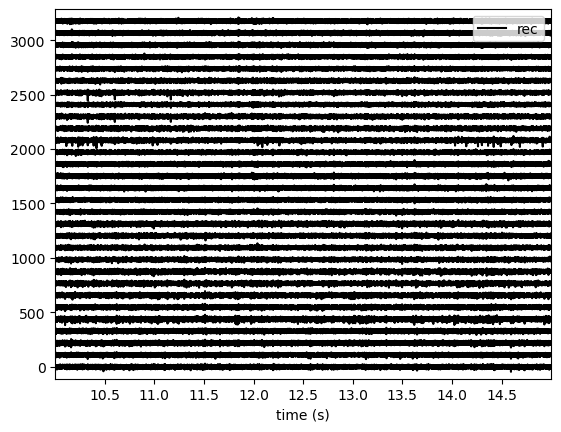

In [41]:
sw.plot_timeseries(recording, channel_ids=np.arange(30), time_range=[10,15])

In [24]:
sgc.Electrode()

nwb_file_name name of the NWB file,electrode_id the unique number for this electrode,probe_type,probe_shank shank number within probe,probe_electrode electrode,region_id,name unique label for each contact,original_reference_electrode the configured reference electrode for this electrode,x the x coordinate of the electrode position in the brain,y the y coordinate of the electrode position in the brain,z the z coordinate of the electrode position in the brain,filtering description of the signal filtering,impedance electrode impedance,"bad_channel if electrode is ""good"" or ""bad"" as observed during recording",x_warped x coordinate of electrode position warped to common template brain,y_warped y coordinate of electrode position warped to common template brain,z_warped z coordinate of electrode position warped to common template brain,contacts label of electrode contacts used for a bipolar signal - current workaround
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,Neuropixels 1.0,0,0,1,0,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,1,Neuropixels 1.0,0,1,1,1,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,2,Neuropixels 1.0,0,2,1,2,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,3,Neuropixels 1.0,0,3,1,3,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,4,Neuropixels 1.0,0,4,1,4,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,5,Neuropixels 1.0,0,5,1,5,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,6,Neuropixels 1.0,0,6,1,6,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,7,Neuropixels 1.0,0,7,1,7,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,8,Neuropixels 1.0,0,8,1,8,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,9,Neuropixels 1.0,0,9,1,9,-1,nan,nan,nan,none,-1.0,False,0.0,0.0,0.0,


In [26]:
sgs.SortGroup()

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,probe_type,probe_shank shank number within probe,"sort_reference_electrode_id the electrode to use for reference. -1: no reference, -2: common median"
sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb,0,Neuropixels 1.0,0,-1


In [10]:
sgc.BrainRegion()

region_id,region_name the name of the brain region,subregion_name subregion name,subsubregion_name subregion within subregion
1,unknown,None,None


In [18]:
sgc.IntervalList().fetch1()

{'nwb_file_name': 'sub-CuffLinks_ses-CuffLinks-LT03-g3_behavior+ecephys_.nwb',
 'interval_list_name': 'raw data valid times',
 'valid_times': array([[   0.       , 1224.9884596]])}

In [20]:
sgc.Electrode()

nwb_file_name name of the NWB file,electrode_group_name electrode group name from NWBFile,electrode_id the unique number for this electrode,probe_type,probe_shank shank number within probe,probe_electrode electrode,region_id,name unique label for each contact,original_reference_electrode the configured reference electrode for this electrode,x the x coordinate of the electrode position in the brain,y the y coordinate of the electrode position in the brain,z the z coordinate of the electrode position in the brain,filtering description of the signal filtering,impedance electrode impedance,"bad_channel if electrode is ""good"" or ""bad"" as observed during recording",x_warped x coordinate of electrode position warped to common template brain,y_warped y coordinate of electrode position warped to common template brain,z_warped z coordinate of electrode position warped to common template brain,contacts label of electrode contacts used for a bipolar signal - current workaround


In [ ]:
a = {'a': 1}
b = dict([1])
print(b)

In [ ]:
sgc.Probe()

In [ ]:
sgc.ElectrodeGroup()

In [ ]:
import spyglass.spikesorting as sgs

In [ ]:
sgc.Probe()

In [ ]:
sgc.Electrode()

In [ ]:
electrodes = (sgc.Electrode() & {'nwb_file_name': nwb_file_name2} & {
                      'bad_channel': 'False'}).fetch()

In [ ]:
e_groups = list(np.unique(electrodes['electrode_group_name']))

In [ ]:
e_groups

In [ ]:
E

In [ ]:
shank_list = np.unique(electrodes['probe_shank'][electrodes['electrode_group_name'] == '0'])

In [ ]:
sgs.SortGroup().set_group_by_shank(nwb_file_name2)

In [ ]:
sgs.SortGroup()

In [ ]:
import probeinterface as pi

from spyglass.common import Probe




In [ ]:
Probe()

In [ ]:
Probe.Electrode()